In [1]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import normalize, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline  
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 400)

# import data

In [2]:
with open("cleaned_data.pkl", 'rb') as picklefile: 
    movie_wide = pickle.load(picklefile)

In [3]:
#TODO what is my goal? Predict opening gross or domestic life gross?

In [4]:
#drop "future" variables unknown at the time of prediction (aim: perdict log_open_gross)
#movie = movie.drop(['life_gross','life_theater', 'rank_num', 'life_frn_gross', 'avg_open_gross', 'pct_open_gross', \
#                    'ww_life_gross', 'pct_life_gross'], axis=1)

In [5]:
#drop "future" variables unknown at the time of prediction (aim: perdict log_life_gross)
movie_wide = movie_wide.drop(['life_theater','rank_num', 'log_life_frn_gross', 'ww_log_life_gross', \
                              'pct_life_gross', 'pct_open_gross'], axis=1)

In [6]:
before_filtering = movie_wide.loc[:, :]
#drop rows w/ too many missings (drop ~5%)
movie_wide = movie_wide.loc[movie_wide['n_miss_mv_cols'] <= 9]

#drop rows w/ too many missings (drop ~33%)
movie_wide = movie_wide.loc[movie_wide['n_miss_mv_cols'] < 9]

# exploratory

In [7]:
movie_wide.tail()

,log_life_gross,log_open_gross,open_theater,n_miss_mv_cols,release_yr,release_mon,release_mon2,release_mon3,release_wday_num,genre_sd,genre_cm,genre_r,genre_cp,mpaa_pg13,mpaa_pg,runtime_mins,log_budget_num,log_avg_open_gross,studio_mv_ct,rank_stu,rank_stu2,rank_stu3,plr_life_mv_num_Actor_0.0,plr_life_mv_num_Actor_1.0,plr_life_mv_num_Director_0.0,plr_life_mv_num_Producer_0.0,plr_life_mv_num_Writer_0.0,plr_log_life_gross_Actor_0.0,plr_log_life_gross_Actor_1.0,plr_log_life_gross_Director_0.0,plr_log_life_gross_Producer_0.0,plr_log_life_gross_Writer_0.0,plr_log_avg_gross_Actor_0.0,plr_log_avg_gross_Actor_1.0,plr_log_avg_gross_Director_0.0,plr_log_avg_gross_Producer_0.0,plr_log_avg_gross_Writer_0.0,plr_open_mv_num_Actor_0.0,plr_open_mv_num_Actor_1.0,plr_open_mv_num_Director_0.0,plr_open_mv_num_Producer_0.0,plr_open_mv_num_Writer_0.0,plr_log_avg_open_gross_Actor_0.0,plr_log_avg_open_gross_Actor_1.0,plr_log_avg_open_gross_Director_0.0,plr_log_avg_open_gross_Producer_0.0,plr_log_avg_open_gross_Writer_0.0,log_life_gross_1yr_Actor_0.0,log_life_gross_1yr_Actor_1.0,log_life_gross_1yr_Director_0.0,log_life_gross_1yr_Producer_0.0,log_life_gross_1yr_Writer_0.0,life_theater_1yr_Actor_0.0,life_theater_1yr_Actor_1.0,life_theater_1yr_Director_0.0,life_theater_1yr_Producer_0.0,life_theater_1yr_Writer_0.0,log_open_gross_1yr_Actor_0.0,log_open_gross_1yr_Actor_1.0,log_open_gross_1yr_Director_0.0,log_open_gross_1yr_Producer_0.0,log_open_gross_1yr_Writer_0.0,open_theater_1yr_Actor_0.0,open_theater_1yr_Actor_1.0,open_theater_1yr_Director_0.0,open_theater_1yr_Producer_0.0,open_theater_1yr_Writer_0.0,rank_num_1yr_Actor_0.0,rank_num_1yr_Actor_1.0,rank_num_1yr_Director_0.0,rank_num_1yr_Producer_0.0,rank_num_1yr_Writer_0.0,log_life_gross_3yr_Actor_0.0,log_life_gross_3yr_Actor_1.0,log_life_gross_3yr_Director_0.0,log_life_gross_3yr_Producer_0.0,log_life_gross_3yr_Writer_0.0,life_theater_3yr_Actor_0.0,life_theater_3yr_Actor_1.0,life_theater_3yr_Director_0.0,life_theater_3yr_Producer_0.0,life_theater_3yr_Writer_0.0,log_open_gross_3yr_Actor_0.0,log_open_gross_3yr_Actor_1.0,log_open_gross_3yr_Director_0.0,log_open_gross_3yr_Producer_0.0,log_open_gross_3yr_Writer_0.0,open_theater_3yr_Actor_0.0,open_theater_3yr_Actor_1.0,open_theater_3yr_Director_0.0,open_theater_3yr_Producer_0.0,open_theater_3yr_Writer_0.0,rank_num_3yr_Actor_0.0,rank_num_3yr_Actor_1.0,rank_num_3yr_Director_0.0,rank_num_3yr_Producer_0.0,rank_num_3yr_Writer_0.0,log_life_gross_5yr_Actor_0.0,log_life_gross_5yr_Actor_1.0,log_life_gross_5yr_Director_0.0,log_life_gross_5yr_Producer_0.0,log_life_gross_5yr_Writer_0.0,life_theater_5yr_Actor_0.0,life_theater_5yr_Actor_1.0,life_theater_5yr_Director_0.0,life_theater_5yr_Producer_0.0,life_theater_5yr_Writer_0.0,log_open_gross_5yr_Actor_0.0,log_open_gross_5yr_Actor_1.0,log_open_gross_5yr_Director_0.0,log_open_gross_5yr_Producer_0.0,log_open_gross_5yr_Writer_0.0,open_theater_5yr_Actor_0.0,open_theater_5yr_Actor_1.0,open_theater_5yr_Director_0.0,open_theater_5yr_Producer_0.0,open_theater_5yr_Writer_0.0,rank_num_5yr_Actor_0.0,rank_num_5yr_Actor_1.0,rank_num_5yr_Director_0.0,rank_num_5yr_Producer_0.0,rank_num_5yr_Writer_0.0,log_life_gross_allyr_Actor_0.0,log_life_gross_allyr_Actor_1.0,log_life_gross_allyr_Director_0.0,log_life_gross_allyr_Producer_0.0,log_life_gross_allyr_Writer_0.0,life_theater_allyr_Actor_0.0,life_theater_allyr_Actor_1.0,life_theater_allyr_Director_0.0,life_theater_allyr_Producer_0.0,life_theater_allyr_Writer_0.0,log_open_gross_allyr_Actor_0.0,log_open_gross_allyr_Actor_1.0,log_open_gross_allyr_Director_0.0,log_open_gross_allyr_Producer_0.0,log_open_gross_allyr_Writer_0.0,open_theater_allyr_Actor_0.0,open_theater_allyr_Actor_1.0,open_theater_allyr_Director_0.0,open_theater_allyr_Producer_0.0,open_theater_allyr_Writer_0.0,rank_num_allyr_Actor_0.0,rank_num_allyr_Actor_1.0,rank_num_allyr_Director_0.0,rank_num_allyr_Producer_0.0,rank_num_allyr_Writer_0.0,log_life_gross_diff31_Actor_0.0,log_life_gross_diff31_Actor_1.0,log_life_gross_diff31_Director_0.0

In [8]:
before_filtering['n_miss_mv_cols'].describe()

count    644.000000
mean       4.211180
std        4.111071
min        0.000000
25%        0.000000
50%        4.000000
75%        9.000000
max       14.000000
Name: n_miss_mv_cols, dtype: float64

In [9]:
before_filtering.loc[before_filtering['n_miss_mv_cols'] <= 9].shape

(616, 168)

In [10]:
before_filtering.loc[before_filtering['n_miss_mv_cols'] < 9].shape

(429, 168)

In [11]:
#for ele in list(movie_wide.columns):
#    if re.match(r".*life.*", ele):
#        print(ele)

In [12]:
movie_wide.shape

(429, 168)

In [13]:
616 / 644 * 100

95.65217391304348

In [14]:
movie_wide.head(1)

,log_life_gross,log_open_gross,open_theater,n_miss_mv_cols,release_yr,release_mon,release_mon2,release_mon3,release_wday_num,genre_sd,genre_cm,genre_r,genre_cp,mpaa_pg13,mpaa_pg,runtime_mins,log_budget_num,log_avg_open_gross,studio_mv_ct,rank_stu,rank_stu2,rank_stu3,plr_life_mv_num_Actor_0.0,plr_life_mv_num_Actor_1.0,plr_life_mv_num_Director_0.0,plr_life_mv_num_Producer_0.0,plr_life_mv_num_Writer_0.0,plr_log_life_gross_Actor_0.0,plr_log_life_gross_Actor_1.0,plr_log_life_gross_Director_0.0,plr_log_life_gross_Producer_0.0,plr_log_life_gross_Writer_0.0,plr_log_avg_gross_Actor_0.0,plr_log_avg_gross_Actor_1.0,plr_log_avg_gross_Director_0.0,plr_log_avg_gross_Producer_0.0,plr_log_avg_gross_Writer_0.0,plr_open_mv_num_Actor_0.0,plr_open_mv_num_Actor_1.0,plr_open_mv_num_Director_0.0,plr_open_mv_num_Producer_0.0,plr_open_mv_num_Writer_0.0,plr_log_avg_open_gross_Actor_0.0,plr_log_avg_open_gross_Actor_1.0,plr_log_avg_open_gross_Director_0.0,plr_log_avg_open_gross_Producer_0.0,plr_log_avg_open_gross_Writer_0.0,log_life_gross_1yr_Actor_0.0,log_life_gross_1yr_Actor_1.0,log_life_gross_1yr_Director_0.0,log_life_gross_1yr_Producer_0.0,log_life_gross_1yr_Writer_0.0,life_theater_1yr_Actor_0.0,life_theater_1yr_Actor_1.0,life_theater_1yr_Director_0.0,life_theater_1yr_Producer_0.0,life_theater_1yr_Writer_0.0,log_open_gross_1yr_Actor_0.0,log_open_gross_1yr_Actor_1.0,log_open_gross_1yr_Director_0.0,log_open_gross_1yr_Producer_0.0,log_open_gross_1yr_Writer_0.0,open_theater_1yr_Actor_0.0,open_theater_1yr_Actor_1.0,open_theater_1yr_Director_0.0,open_theater_1yr_Producer_0.0,open_theater_1yr_Writer_0.0,rank_num_1yr_Actor_0.0,rank_num_1yr_Actor_1.0,rank_num_1yr_Director_0.0,rank_num_1yr_Producer_0.0,rank_num_1yr_Writer_0.0,log_life_gross_3yr_Actor_0.0,log_life_gross_3yr_Actor_1.0,log_life_gross_3yr_Director_0.0,log_life_gross_3yr_Producer_0.0,log_life_gross_3yr_Writer_0.0,life_theater_3yr_Actor_0.0,life_theater_3yr_Actor_1.0,life_theater_3yr_Director_0.0,life_theater_3yr_Producer_0.0,life_theater_3yr_Writer_0.0,log_open_gross_3yr_Actor_0.0,log_open_gross_3yr_Actor_1.0,log_open_gross_3yr_Director_0.0,log_open_gross_3yr_Producer_0.0,log_open_gross_3yr_Writer_0.0,open_theater_3yr_Actor_0.0,open_theater_3yr_Actor_1.0,open_theater_3yr_Director_0.0,open_theater_3yr_Producer_0.0,open_theater_3yr_Writer_0.0,rank_num_3yr_Actor_0.0,rank_num_3yr_Actor_1.0,rank_num_3yr_Director_0.0,rank_num_3yr_Producer_0.0,rank_num_3yr_Writer_0.0,log_life_gross_5yr_Actor_0.0,log_life_gross_5yr_Actor_1.0,log_life_gross_5yr_Director_0.0,log_life_gross_5yr_Producer_0.0,log_life_gross_5yr_Writer_0.0,life_theater_5yr_Actor_0.0,life_theater_5yr_Actor_1.0,life_theater_5yr_Director_0.0,life_theater_5yr_Producer_0.0,life_theater_5yr_Writer_0.0,log_open_gross_5yr_Actor_0.0,log_open_gross_5yr_Actor_1.0,log_open_gross_5yr_Director_0.0,log_open_gross_5yr_Producer_0.0,log_open_gross_5yr_Writer_0.0,open_theater_5yr_Actor_0.0,open_theater_5yr_Actor_1.0,open_theater_5yr_Director_0.0,open_theater_5yr_Producer_0.0,open_theater_5yr_Writer_0.0,rank_num_5yr_Actor_0.0,rank_num_5yr_Actor_1.0,rank_num_5yr_Director_0.0,rank_num_5yr_Producer_0.0,rank_num_5yr_Writer_0.0,log_life_gross_allyr_Actor_0.0,log_life_gross_allyr_Actor_1.0,log_life_gross_allyr_Director_0.0,log_life_gross_allyr_Producer_0.0,log_life_gross_allyr_Writer_0.0,life_theater_allyr_Actor_0.0,life_theater_allyr_Actor_1.0,life_theater_allyr_Director_0.0,life_theater_allyr_Producer_0.0,life_theater_allyr_Writer_0.0,log_open_gross_allyr_Actor_0.0,log_open_gross_allyr_Actor_1.0,log_open_gross_allyr_Director_0.0,log_open_gross_allyr_Producer_0.0,log_open_gross_allyr_Writer_0.0,open_theater_allyr_Actor_0.0,open_theater_allyr_Actor_1.0,open_theater_allyr_Director_0.0,open_theater_allyr_Producer_0.0,open_theater_allyr_Writer_0.0,rank_num_allyr_Actor_0.0,rank_num_allyr_Actor_1.0,rank_num_allyr_Director_0.0,rank_num_allyr_Producer_0.0,rank_num_allyr_Writer_0.0,log_life_gross_diff31_Actor_0.0,log_life_gross_diff31_Actor_1.0,log_life_gross_diff31_Director_0.0

In [15]:
movie_wide.shape[0] / 12 # best to have <= 50 vars?

35.75

In [16]:
movie_wide.describe()

,log_life_gross,log_open_gross,open_theater,n_miss_mv_cols,release_yr,release_mon,release_mon2,release_mon3,release_wday_num,mpaa_pg13,mpaa_pg,runtime_mins,log_budget_num,log_avg_open_gross,studio_mv_ct,rank_stu,rank_stu2,rank_stu3,plr_life_mv_num_Actor_0.0,plr_life_mv_num_Actor_1.0,plr_life_mv_num_Director_0.0,plr_life_mv_num_Producer_0.0,plr_life_mv_num_Writer_0.0,plr_log_life_gross_Actor_0.0,plr_log_life_gross_Actor_1.0,plr_log_life_gross_Director_0.0,plr_log_life_gross_Producer_0.0,plr_log_life_gross_Writer_0.0,plr_log_avg_gross_Actor_0.0,plr_log_avg_gross_Actor_1.0,plr_log_avg_gross_Director_0.0,plr_log_avg_gross_Producer_0.0,plr_log_avg_gross_Writer_0.0,plr_open_mv_num_Actor_0.0,plr_open_mv_num_Actor_1.0,plr_open_mv_num_Director_0.0,plr_open_mv_num_Producer_0.0,plr_open_mv_num_Writer_0.0,plr_log_avg_open_gross_Actor_0.0,plr_log_avg_open_gross_Actor_1.0,plr_log_avg_open_gross_Director_0.0,plr_log_avg_open_gross_Producer_0.0,plr_log_avg_open_gross_Writer_0.0,log_life_gross_1yr_Actor_0.0,log_life_gross_1yr_Actor_1.0,log_life_gross_1yr_Director_0.0,log_life_gross_1yr_Producer_0.0,log_life_gross_1yr_Writer_0.0,life_theater_1yr_Actor_0.0,life_theater_1yr_Actor_1.0,life_theater_1yr_Director_0.0,life_theater_1yr_Producer_0.0,life_theater_1yr_Writer_0.0,log_open_gross_1yr_Actor_0.0,log_open_gross_1yr_Actor_1.0,log_open_gross_1yr_Director_0.0,log_open_gross_1yr_Producer_0.0,log_open_gross_1yr_Writer_0.0,open_theater_1yr_Actor_0.0,open_theater_1yr_Actor_1.0,open_theater_1yr_Director_0.0,open_theater_1yr_Producer_0.0,open_theater_1yr_Writer_0.0,rank_num_1yr_Actor_0.0,rank_num_1yr_Actor_1.0,rank_num_1yr_Director_0.0,rank_num_1yr_Producer_0.0,rank_num_1yr_Writer_0.0,log_life_gross_3yr_Actor_0.0,log_life_gross_3yr_Actor_1.0,log_life_gross_3yr_Director_0.0,log_life_gross_3yr_Producer_0.0,log_life_gross_3yr_Writer_0.0,life_theater_3yr_Actor_0.0,life_theater_3yr_Actor_1.0,life_theater_3yr_Director_0.0,life_theater_3yr_Producer_0.0,life_theater_3yr_Writer_0.0,log_open_gross_3yr_Actor_0.0,log_open_gross_3yr_Actor_1.0,log_open_gross_3yr_Director_0.0,log_open_gross_3yr_Producer_0.0,log_open_gross_3yr_Writer_0.0,open_theater_3yr_Actor_0.0,open_theater_3yr_Actor_1.0,open_theater_3yr_Director_0.0,open_theater_3yr_Producer_0.0,open_theater_3yr_Writer_0.0,rank_num_3yr_Actor_0.0,rank_num_3yr_Actor_1.0,rank_num_3yr_Director_0.0,rank_num_3yr_Producer_0.0,rank_num_3yr_Writer_0.0,log_life_gross_5yr_Actor_0.0,log_life_gross_5yr_Actor_1.0,log_life_gross_5yr_Director_0.0,log_life_gross_5yr_Producer_0.0,log_life_gross_5yr_Writer_0.0,life_theater_5yr_Actor_0.0,life_theater_5yr_Actor_1.0,life_theater_5yr_Director_0.0,life_theater_5yr_Producer_0.0,life_theater_5yr_Writer_0.0,log_open_gross_5yr_Actor_0.0,log_open_gross_5yr_Actor_1.0,log_open_gross_5yr_Director_0.0,log_open_gross_5yr_Producer_0.0,log_open_gross_5yr_Writer_0.0,open_theater_5yr_Actor_0.0,open_theater_5yr_Actor_1.0,open_theater_5yr_Director_0.0,open_theater_5yr_Producer_0.0,open_theater_5yr_Writer_0.0,rank_num_5yr_Actor_0.0,rank_num_5yr_Actor_1.0,rank_num_5yr_Director_0.0,rank_num_5yr_Producer_0.0,rank_num_5yr_Writer_0.0,log_life_gross_allyr_Actor_0.0,log_life_gross_allyr_Actor_1.0,log_life_gross_allyr_Director_0.0,log_life_gross_allyr_Producer_0.0,log_life_gross_allyr_Writer_0.0,life_theater_allyr_Actor_0.0,life_theater_allyr_Actor_1.0,life_theater_allyr_Director_0.0,life_theater_allyr_Producer_0.0,life_theater_allyr_Writer_0.0,log_open_gross_allyr_Actor_0.0,log_open_gross_allyr_Actor_1.0,log_open_gross_allyr_Director_0.0,log_open_gross_allyr_Producer_0.0,log_open_gross_allyr_Writer_0.0,open_theater_allyr_Actor_0.0,open_theater_allyr_Actor_1.0,open_theater_allyr_Director_0.0,open_theater_allyr_Producer_0.0,open_theater_allyr_Writer_0.0,rank_num_allyr_Actor_0.0,rank_num_allyr_Actor_1.0,rank_num_allyr_Director_0.0,rank_num_allyr_Producer_0.0,rank_num_allyr_Writer_0.0,log_life_gross_diff31_Actor_0.0,log_life_gross_diff31_Actor_1.0,log_life_gross_diff31_Director_0.0,log_life_gross_diff31_Producer_0.0

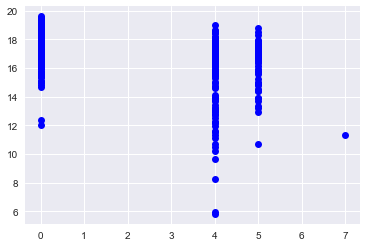

In [17]:
#plt.plot(movie_wide['avg_open_gross'].map(np.log), movie_wide['log_life_gross'], 'bo')
plt.plot(movie_wide['n_miss_mv_cols'], movie_wide['log_life_gross'], 'bo')

In [18]:
100- (429 / 644 * 100)

33.38509316770187

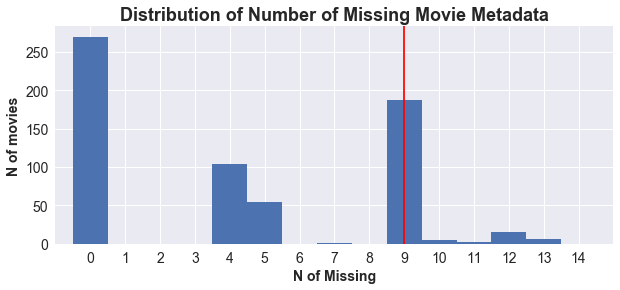

In [19]:
plt.figure(figsize = (10, 4))
plt.hist(before_filtering['n_miss_mv_cols'], bins = 14, align = 'left')
plt.title("Distribution of Number of Missing Movie Metadata", fontweight = 'bold', fontsize = 18)
plt.ylabel("N of movies", fontweight = 'bold', fontsize = 14)
plt.xlabel("N of Missing", fontweight = 'bold', fontsize = 14)
plt.xticks(list(range(15)), fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlim((-1, 15))
plt.axvline(x = 9, color = 'red')
plt.show()

In [20]:
some_stuff = movie_wide.copy()
some_stuff.loc[3000 < some_stuff['studio_mv_ct'] , 'bins'] = '4'
some_stuff.loc[(2500 < some_stuff['studio_mv_ct']) & (some_stuff['studio_mv_ct'] < 3000), 'bins'] = '3'
some_stuff.loc[(1500 < some_stuff['studio_mv_ct']) & (some_stuff['studio_mv_ct'] < 2500), 'bins'] = '2'
some_stuff.loc[some_stuff['studio_mv_ct'] < 1500, 'bins'] = '1'

num_obs = np.array(some_stuff.groupby('bins').count()['log_life_gross'].map(str))
val_label = np.array(['<1500', '1500-2500', '2500-3000 (Univ)', '>3000 (WB)'])
tick_val = ["".join(x) for x in list(zip(val_label, ['\nn='] * 4, num_obs))]

num_obs2 = np.array(some_stuff.groupby('release_mon').count()['log_life_gross'].map(str))
val_label2 = np.array(pd.Series(range(1, 13)).map(str))
tick_val2 = ["".join(x) for x in list(zip(val_label2, ['\nn='] * 12, num_obs2))]

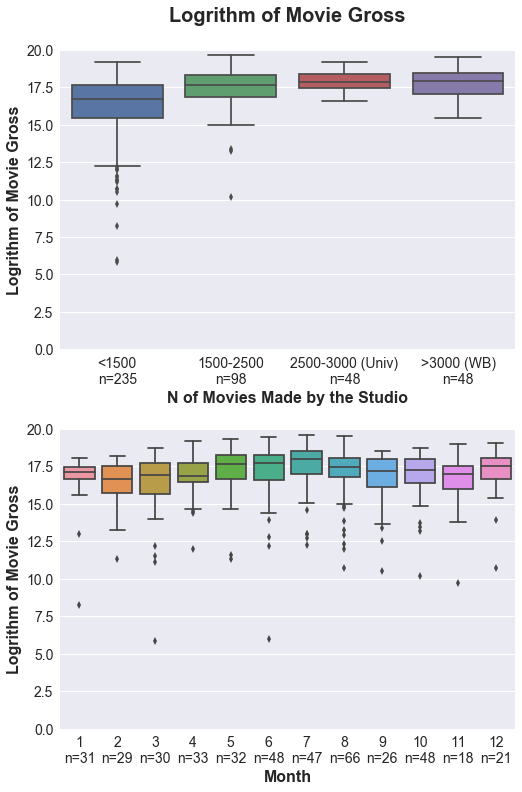

In [21]:
fig, ax = plt.subplots(2, 1, figsize = (7, 10))
plt.tight_layout(h_pad = 6)
plt.subplot(2, 1, 1)
sns.boxplot(x = some_stuff['bins'], y = some_stuff['log_life_gross'])
plt.xticks(plt.xticks()[0], tick_val, fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylim((0, 20))
plt.title("Logrithm of Movie Gross\n", fontweight = 'bold', fontsize = 20)
plt.ylabel("Logrithm of Movie Gross", fontweight = 'bold', fontsize = 16)
plt.xlabel("N of Movies Made by the Studio", fontweight = 'bold', fontsize = 16)

plt.subplot(2, 1, 2)
sns.boxplot(x = movie_wide['release_mon'], y = movie_wide['log_life_gross'])
plt.xticks(plt.xticks()[0], tick_val2, fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel("Logrithm of Movie Gross", fontweight = 'bold', fontsize = 16)
plt.xlabel("Month", fontweight = 'bold', fontsize = 16)
plt.ylim((0, 20))
plt.show()

In [22]:
get_hue = movie_wide.copy()
get_hue['Log Movie Gross'] = (get_hue['log_open_gross'] > np.percentile(movie_wide['log_open_gross'], 75)).map(str)
get_hue.loc[get_hue['Log Movie Gross'] == 'True', 'Log Movie Gross'] = "Top 25%"
get_hue.loc[get_hue['Log Movie Gross'] == 'False', 'Log Movie Gross'] = "Bottom 75%"
get_hue = get_hue.rename(index=str, columns={"open_theater": "N of Theaters", 
                                   "log_open_gross_1yr_Writer_0.0": "1 Yr Log Gross of Writer",
                                   "plr_log_avg_gross_Actor_0.0": "Avg Log Gross of Actor",
                                   "log_open_gross_allyr_Writer_0.0": "Lifetime Log Gross of Writer"
                                  })

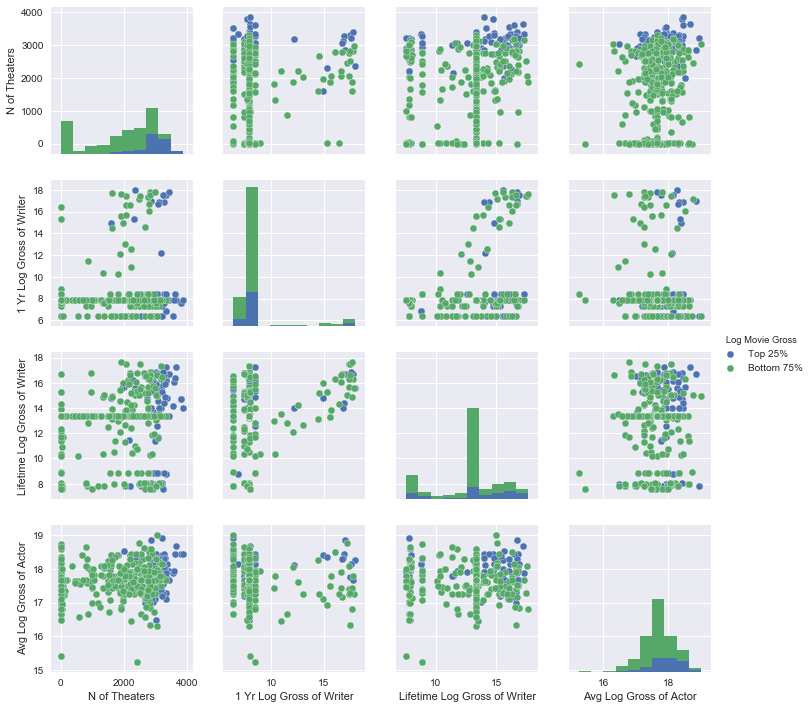

In [23]:
sns.pairplot(get_hue, hue = "Log Movie Gross", vars = ['N of Theaters', '1 Yr Log Gross of Writer', \
                                           'Lifetime Log Gross of Writer', 'Avg Log Gross of Actor'])

# split data

In [24]:
#TODO
#normalize
#preprocessing. polynomial(degree = 2)

In [25]:
X_everything = movie_wide.drop(['log_life_gross'], axis=1)
#X_everything_nmz = pd.DataFrame(normalize(X_everything), columns = X_everything.columns, index = X_everything.index)
y_everything = movie_wide[['log_life_gross']]

In [26]:
#add poly features
poly = PolynomialFeatures(degree = 2, include_bias = False)
poly.fit(X_everything)
cols = poly.get_feature_names(input_features = X_everything.columns)
X_everything = pd.DataFrame(poly.transform(X_everything), columns = cols, index = X_everything.index)

In [27]:
#hold-out set
X, X_holdout, y, y_holdout = train_test_split(X_everything, y_everything, test_size=0.2, random_state=1)

# reduce features

In [ ]:
#TODO use KFold

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)

### random forest

In [29]:
rf = RandomForestRegressor(n_estimators=100, random_state=6) #n_estimators=250
rf.fit(X_train, y_train)
imp = rf.feature_importances_
imp = pd.DataFrame(np.array(imp).T, columns = ['imp'], index = X_everything.columns)
imp.sort_values('imp', ascending = False, inplace = True)

### ANOVA F-score using simple linear regression 

In [ ]:
#DOESN'T ACCOUNT FOR INTERACTION
#imp = f_regression(X, y)
#imp = pd.DataFrame(np.array(imp).T, columns = ['F', 'pval'], index = X_everything.columns)
#imp.sort_values('pval', inplace = True)
#imp['<0.05'] = feature_sig['pval'] < 0.05

### LASSO

In [ ]:
#TODO

### plot error vs num of features

In [30]:
lm = LinearRegression()
num_fetures_perf_df = pd.DataFrame(columns = ['num_fetures', 'tr_mse', 'ts_mse', 'tr_r2', 'ts_r2'])
for num_fetures in range(2, 101, 2): #imp.shape[0] + 1, 5):
    feature_cols = list(imp.iloc[:num_fetures].index)
    lm.fit(X_train.loc[:, feature_cols], y_train)
    tr_mse = mean_squared_error(y_train, lm.predict(X_train.loc[:, feature_cols]))
    ts_mse = mean_squared_error(y_test, lm.predict(X_test.loc[:, feature_cols]))
    tr_r2 = r2_score(y_train, lm.predict(X_train.loc[:, feature_cols]))
    ts_r2 = r2_score(y_test, lm.predict(X_test.loc[:, feature_cols]))
    num_fetures_perf_df = num_fetures_perf_df.append({'num_fetures': num_fetures, \
                                                      'tr_mse': tr_mse, \
                                                      'ts_mse': ts_mse, \
                                                      'tr_r2': tr_r2, \
                                                      'ts_r2': ts_r2}, ignore_index=True)

In [31]:
num_fetures_perf_df['rank_ts_mse'] = num_fetures_perf_df['ts_mse'].rank(axis = 0, method = 'dense')
num_fetures_perf_df['rank_ts_r2'] = num_fetures_perf_df['ts_r2'].rank(axis = 0, ascending = False, method = 'dense')
num_fetures_perf_df['avg_rank'] = (num_fetures_perf_df['rank_ts_mse'] + num_fetures_perf_df['rank_ts_r2']) / 2

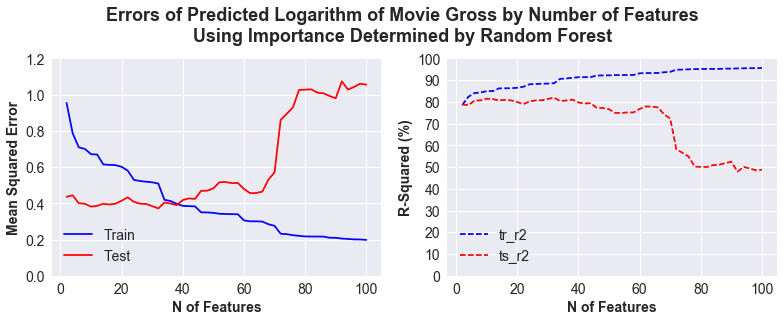

In [32]:
plt.subplots(1, 2, figsize = (13, 4))
plt.subplot(1, 2, 1)
plt.suptitle("Errors of Predicted Logarithm of Movie Gross by Number of Features\nUsing Importance Determined by Random Forest", \
          fontweight = 'bold', fontsize = 18, y=1.06)

plt.plot(num_fetures_perf_df['num_fetures'], num_fetures_perf_df['tr_mse'], 'b-', label = "Train")
plt.plot(num_fetures_perf_df['num_fetures'], num_fetures_perf_df['ts_mse'], 'r-', label = "Test")

plt.xlabel("N of Features", fontweight = 'bold', fontsize = 14)
plt.ylabel("Mean Squared Error", fontweight = 'bold', fontsize = 14)
plt.yticks(np.array(range(0, 13, 2)) / 10, fontsize = 14)
plt.xticks(fontsize = 14)
plt.legend(fontsize = 14)

plt.subplot(1, 2, 2)
plt.plot(num_fetures_perf_df['num_fetures'], num_fetures_perf_df['tr_r2'] * 100, 'b--')
plt.plot(num_fetures_perf_df['num_fetures'], num_fetures_perf_df['ts_r2'] * 100, 'r--')
plt.xlabel("N of Features", fontweight = 'bold', fontsize = 14)
plt.ylabel(r"R-Squared (%)", fontweight = 'bold', fontsize = 14)
plt.yticks(range(0, 101, 10), fontsize = 14)
plt.xticks(fontsize = 14)
plt.legend(fontsize = 14)
plt.show()

In [33]:
#cond = (num_fetures_perf_df['rank_ts_mse'] < 10) & (num_fetures_perf_df['rank_ts_r2'] < 10)
#num_fetures_perf_df.loc[cond]
#num_fetures_perf_df

In [34]:
cond = num_fetures_perf_df['avg_rank'] == min(num_fetures_perf_df['avg_rank'])
final_n_cols = int(num_fetures_perf_df.loc[cond, 'num_fetures'])
final_n_cols

32

# build model

In [35]:
final_cols = list(imp.iloc[:final_n_cols].index)

In [36]:
kf = KFold(n_splits=5, shuffle=True, random_state=7)

In [37]:
alpha_range = np.array(range(0, 1001, 5)) / 1000 #np.array(range(0, 21, 1)) / 10
#alpha_range

In [38]:
alpha_tuning_df = pd.DataFrame(columns = ['alpha', 'tr_mse', 'ts_mse', 'tr_r2', 'ts_r2'])
for alpha in alpha_range: 
    model = Lasso(alpha = alpha)
    for train_index, test_index in kf.split(X):
        X_train = X.iloc[train_index].loc[:, final_cols]
        X_test = X.iloc[test_index].loc[:, final_cols]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]
        model.fit(X_train, y_train)
        tr_mse = mean_squared_error(y_train, model.predict(X_train))
        ts_mse = mean_squared_error(y_test, model.predict(X_test))
        tr_r2 = r2_score(y_train, model.predict(X_train))
        ts_r2 = r2_score(y_test, model.predict(X_test))
        alpha_tuning_df = alpha_tuning_df.append({'alpha': alpha, \
                                                  'tr_mse': tr_mse, \
                                                  'ts_mse': ts_mse, \
                                                  'tr_r2': tr_r2, \
                                                  'ts_r2': ts_r2}, ignore_index=True)
#alpha_tuning_df

In [39]:
avg_alpha_tuning_df = alpha_tuning_df.groupby('alpha').mean()
avg_alpha_tuning_df.reset_index(inplace = True)
avg_alpha_tuning_df['rank_ts_mse'] = avg_alpha_tuning_df['ts_mse'].rank(axis = 0, method = 'dense')
avg_alpha_tuning_df['rank_ts_r2'] = avg_alpha_tuning_df['ts_r2'].rank(axis = 0, ascending = False, method = 'dense')
avg_alpha_tuning_df['avg_rank'] = (avg_alpha_tuning_df['rank_ts_mse'] + avg_alpha_tuning_df['rank_ts_r2']) / 2

In [40]:
avg_alpha_tuning_df.sort_values('avg_rank', inplace = True)
avg_alpha_tuning_df.head()

,alpha,tr_mse,ts_mse,tr_r2,ts_r2,rank_ts_mse,rank_ts_r2,avg_rank
48,0.240,0.510422,0.590982,0.863244,0.841926,1.0,1.0,1.0
47,0.235,0.509725,0.591045,0.863438,0.841911,2.0,2.0,2.0
46,0.230,0.509017,0.591169,0.863635,0.841883,3.0,3.0,3.0
45,0.225,0.508313,0.591334,0.863831,0.841841,4.0,5.0,4.5
49,0.245,0.510996,0.591399,0.863089,0.841854,5.0,4.0,4.5


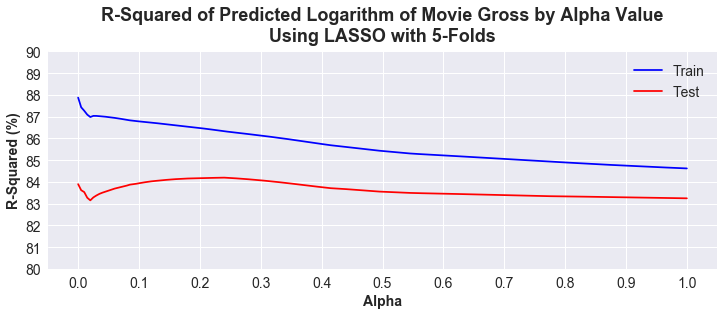

In [41]:
avg_alpha_tuning_df.sort_values('alpha', inplace = True)
plt.figure(figsize = (12, 4))
plt.plot(avg_alpha_tuning_df['alpha'], avg_alpha_tuning_df['tr_r2'] * 100, 'b-', label = "Train")
plt.plot(avg_alpha_tuning_df['alpha'], avg_alpha_tuning_df['ts_r2'] * 100, 'r-', label = "Test")
plt.xlabel("Alpha", fontweight = 'bold', fontsize = 14)
plt.ylabel(r"R-Squared (%)", fontweight = 'bold', fontsize = 14)
plt.title("R-Squared of Predicted Logarithm of Movie Gross by Alpha Value\nUsing LASSO with 5-Folds", \
          fontweight = 'bold', fontsize = 18, y=1.02)
plt.yticks(range(80, 91, 1), fontsize = 14)
plt.xticks(np.array(range(0, 11, 1)) / 10, fontsize = 14)
plt.legend(fontsize = 14)
plt.show()

In [42]:
cond = avg_alpha_tuning_df['avg_rank'] == min(avg_alpha_tuning_df['avg_rank'])
final_alpha = float(avg_alpha_tuning_df.loc[cond, 'alpha'])
final_alpha

0.24

# final model and predict hold-out set

In [43]:
X = X.loc[:, final_cols]
X_holdout = X_holdout.loc[:, final_cols]
final_model = Lasso(alpha = final_alpha)
final_fit = final_model.fit(X, y)

In [47]:
print(r"Final Model: LASSO (alpha=" + str(final_alpha) + r")")

Final Model: LASSO (alpha=0.24)


### MSE and R-squred for training and holdout set

In [48]:
tr_mse = mean_squared_error(y, final_model.predict(X))
ts_mse = mean_squared_error(y_holdout, final_model.predict(X_holdout))
tr_r2 = r2_score(y, final_model.predict(X))
ts_r2 = r2_score(y_holdout, final_model.predict(X_holdout))
print('tr_mse:', str(round(tr_mse, 4)))
print('ts_mse:', str(round(ts_mse, 4)))
print('tr_r2:', str(round(tr_r2 * 100, 4)) + r'%')
print('ts_r2:', str(round(ts_r2 * 100, 4)) + r'%')

tr_mse: 0.5189
ts_mse: 0.5143
tr_r2: 86.1033%
ts_r2: 85.6635%


In [49]:
print(y.shape, "\n", y_holdout.shape)

(343, 1) 
 (86, 1)


### get prediction

In [50]:
y_pred = final_model.predict(X_holdout)
compare_y = pd.DataFrame({'y_holdout': y_holdout['log_life_gross'], 'y_pred': y_pred})
compare_y['orig_y_holdout'] = np.exp(y_holdout['log_life_gross'])
compare_y['orig_y_pred'] = np.exp(y_pred)
compare_y['abs_diff'] = abs(compare_y['y_pred'] - compare_y['y_holdout'])
compare_y.sort_values(by = 'abs_diff', inplace = True)
#compare_y.tail()

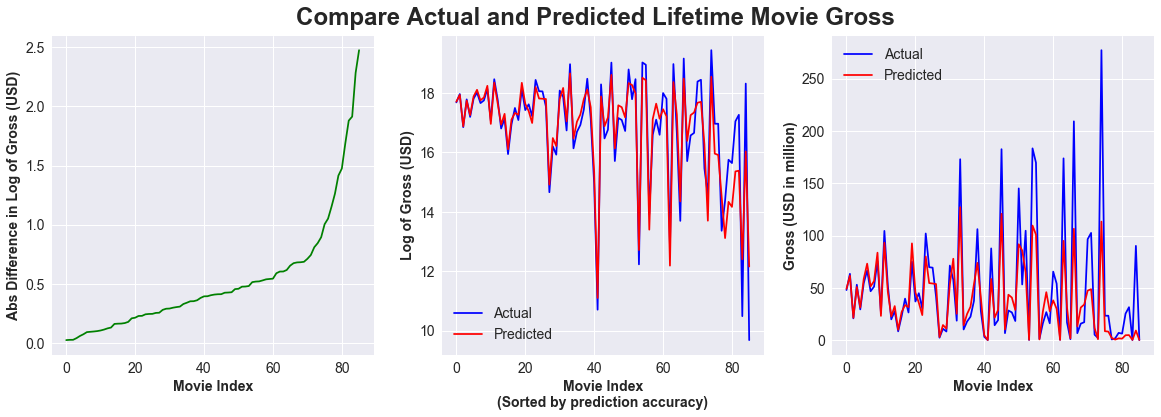

In [51]:
plt.subplots(1, 3, figsize = (16, 5))
plt.tight_layout(w_pad = 4)
x_axis = np.arange(compare_y.shape[0])
plt.suptitle("Compare Actual and Predicted Lifetime Movie Gross", fontweight = 'bold', fontsize = 24, y = 1.04)
plt.subplot(1, 3, 1)
plt.plot(x_axis, compare_y['abs_diff'], 'g-')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel(r"Movie Index", fontweight = 'bold', fontsize = 14)
plt.ylabel("Abs Difference in Log of Gross (USD)", fontweight = 'bold', fontsize = 14)

plt.subplot(1, 3, 2)
plt.plot(x_axis, compare_y['y_holdout'], 'b-', label = "Actual")
plt.plot(x_axis, compare_y['y_pred'], 'r-', label = "Predicted")
plt.legend(fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel("Movie Index\n(Sorted by prediction accuracy)", fontweight = 'bold', fontsize = 14)
plt.ylabel("Log of Gross (USD)", fontweight = 'bold', fontsize = 14)

plt.subplot(1, 3, 3)
plt.plot(x_axis, compare_y['orig_y_holdout'] / 10**6, 'b-', label = "Actual")
plt.plot(x_axis, compare_y['orig_y_pred'] / 10**6, 'r-', label = "Predicted")
plt.legend(fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel("Movie Index", fontweight = 'bold', fontsize = 14)
plt.ylabel("Gross (USD in million)", fontweight = 'bold', fontsize = 14)
plt.title(r"")
plt.show()

### look at coef

In [52]:
final_coef = pd.DataFrame(final_fit.coef_, columns = ['est_beta'], index = final_cols)
final_coef['rank_beta'] = final_coef['est_beta'].map(abs).rank(axis = 0, ascending = False, method = 'dense')
final_coef.sort_values('rank_beta', inplace = True)

In [53]:
final_coef#.head()

,est_beta,rank_beta
log_open_gross n_plrs,-3.457809e-02,1.0
log_avg_open_gross n_plrs,2.294127e-02,2.0
log_open_gross^2,-1.059869e-02,3.0
rank_stu n_plrs,9.689809e-03,4.0
log_open_gross plr_log_life_gross_Director_0.0,3.992619e-03,5.0
log_open_gross plr_log_life_gross_Actor_0.0,3.761880e-03,6.0
log_open_gross log_life_gross_3yr_Writer_0.0,2.245443e-03,7.0
log_open_gross log_open_gross_3yr_Writer_0.0,-1.920940e-03,8.0
log_open_gross plr_log_life_gross_Actor_1.0,1.150081e-03,9.0
log_open_gross log_budget_num,8.922102e-04,10.0
